## 20_engineer_earthquake_data.ipynb
<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"><b>This script cleans, engineers, and selects earthquake data from the USGS database.</b> The main parts of the routines were developed in previous courses at the University of London by the same author (Mohr, 2021, 2023, 2024a) and have been further refined to meet the needs of this MSc thesis project/research. However, the code has been updated to comply with the latest requirements and package interdependencies. Some comments will be included in this Jupyter Notebook, and the code contains several inline comments. For details on the project/research itself, refer to the appropriate document.

#### References (for this script)
*Mohr, S. (2021) Regional Spatial Clusters of Earthquakes at the Pacific Ring of Fire: Analysing Data from the USGS ANSS ComCat and Building Regional Spatial Clusters. DSM020, Python, examined coursework cw1. University of London.*

*Mohr, S. (2023) Clustering of Earthquakes on a Worldwide Scale with the Help of Big Data Machine Learning Methods. DSM010, Big Data, examined coursework cw2. University of London.*

*Mohr, S. (2024a) Comparing Different Tectonic Setups Considering Publicly Available Basic Earthquake’s Data. DSM050, Data Visualisation, examined coursework cw1. University of London.*

#### History
<pre>
250103 Generation from previous courseworks at the UoL, setup basic logging, improve error handling for loading the
       data, export load_dataset to shared_procedures.py, add basic information and statistics, clean all data, 
       engineer all data, display some figures for categorcial and numeric data, save dataset, prepare additional
       figures, analyse and set datatype for all (incl. engineered) columns, add system information, re-structure
       the script, add listing headlines
250104 Improve error handling when inserting new columns, check final dataset
250105 Move shared procedures to shared_procedures.py, spatial fitting ensured by parameterized data scraping,
       omit all events with status=automatic
</pre>

#### Todo
<pre>./.</pre>

## Preparing the environment
### System information

In [1]:
# which python installation and version are we using here?
print('\n******* Python Info ***********')
!which python
!python --version

# show some CPU and RAM info
print('\n******* CPU Info ***********')
!lscpu
print('\n******* RAM Info (in GB) ***********')
!free -g


******* Python Info ***********
/bin/python
Python 3.8.10

******* CPU Info ***********
Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             64
On-line CPU(s) list:                0-63
Thread(s) per core:                 2
Core(s) per socket:                 8
Socket(s):                          4
NUMA node(s):                       4
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) Gold 6234 CPU @ 3.30GHz
Stepping:                           7
CPU MHz:                            1200.084
CPU max MHz:                        4000.0000
CPU min MHz:                        1200.0000
BogoMIPS:                           6600.00
Virtualization:                     VT-x
L1

In [2]:
# show installed packages and versions
!pip freeze

absl-py==2.1.0
affine==2.4.0
aggdraw==1.3.16
array-record==0.4.0
asttokens==2.4.1
astunparse==1.6.3
atomicwrites==1.1.5
attrs==19.3.0
Automat==0.8.0
backcall==0.2.0
beautifulsoup4==4.8.2
blinker==1.4
cachetools==5.5.0
certifi==2019.11.28
chardet==3.0.4
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloud-init==24.3.1
colorama==0.4.3
comm==0.2.2
command-not-found==0.3
configobj==5.0.6
confluent-kafka==2.5.3
constantly==15.1.0
contextily==1.5.2
contourpy==1.1.1
cryptography==2.8
cupshelpers==1.0
cycler==0.10.0
dbus-python==1.2.16
debugpy==1.8.7
decorator==4.4.2
defer==1.0.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
dm-tree==0.1.8
entrypoints==0.3
et-xmlfile==1.0.1
etils==1.3.0
executing==2.0.1
fail2ban==0.11.1
fastjsonschema==2.20.0
filelock==3.13.1
fiona==1.9.6
flatbuffers==24.3.25
fonttools==4.53.1
fsspec==2023.12.2
ftfy==6.2.0
gast==0.4.0
geographiclib==2.0
geopandas==0.13.2
geopy==2.4.1
google-auth==2.36.0
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
googleapis-common-protos==1.66

### Setting PATH correctly

In [3]:
# there is somewhere a PATH-error on LENA for a while
# adding my packages path to the PATH environment

import sys
sys.path.append("/home/smohr001/.local/lib/python3.8/site-packages")
sys.path

['/home/smohr001/thesis',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/opt/jupyterhub/lib/python3.8/site-packages',
 '/opt/jupyterhub/lib/python3.8/site-packages/IPython/extensions',
 '/home/smohr001/.ipython',
 '/home/smohr001/.local/lib/python3.8/site-packages']

### Loading libraries

In [4]:
# importing standard libraries
import sys
import os
import warnings
import datetime
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import logging

# importing shared procedures for this procect (needs to be a simple .py file)
%run shared_procedures.py

# importing additional libraries
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

# get info about installed and used versions of some important (deep learning) libraries
print("Some important installed libraries:\n")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")

Some important installed libraries:

Pandas version: 1.4.1
Numpy version: 1.22.2
Seaborn version: 0.13.2


### Setting the script environment

In [5]:
# show all matplotlib graphs inline
%matplotlib inline

# setting format to JPG for easy copy & paste for figures
# for high quality outputs choose 'svg'
%config InlineBackend.figure_format = 'jpg'

# adjust display settings to show 20 rows as a standard
pd.set_option('display.max_rows', 20)

# disable warnings (activate after developing the complete code)
warnings.filterwarnings('ignore')

# set script (ipynb notebook) name (e.g. for logging)
script_name = "20_engineer_earthquake_data.ipynb"

# start parameterized logging
setup_logging(logfile_dir = "log", 
              logfile_name = "20_engineer_data.log", 
              log_level = logging.INFO, 
              script_name = script_name
             )

# set data directory
data_dir = "data"
logging.info(f"{script_name}: Set data directory to './{data_dir}'.")

2025-01-10 13:16:28,643 - INFO - Starting script '20_engineer_earthquake_data.ipynb'.
2025-01-10 13:16:28,644 - INFO - Set loglevel to INFO.
2025-01-10 13:16:28,644 - INFO - 20_engineer_earthquake_data.ipynb: Set data directory to './data'.


In [6]:
# set fixed seed for reproducibility
reset_random_seeds(script_name=script_name)

2025-01-10 13:16:28,647 - INFO - 20_engineer_earthquake_data.ipynb: Seeding random generators with seed=654321.


## Loading data

In [7]:
# load scraped dataset
earthquakes_scraped = load_dataset(data_file="earthquakes_scraped.csv", data_dir="data")    

2025-01-10 13:16:28,728 - INFO - load_dataset: Data loaded successfully from 'data/earthquakes_scraped.csv'.


## Statistics and information

In [8]:
# infos of the dataset
print("\nShape:\n" + str(earthquakes_scraped.shape))
print("\nColumns and DataTypes:\n" + str(earthquakes_scraped.dtypes))
display(earthquakes_scraped)
logging.info(f"{script_name}: Used dataset is 'earthquakes_scraped' with {earthquakes_scraped.shape}.")


Shape:
(63878, 15)

Columns and DataTypes:
id          object
lon        float64
lat        float64
depth      float64
mag        float64
time         int64
felt       float64
cdi        float64
mmi        float64
alert       object
status      object
tsunami      int64
nst          int64
net         object
sig        float64
dtype: object


,id,lon,lat,depth,mag,time,felt,cdi,mmi,alert,status,tsunami,nst,net,sig
0,usp00000hw,-101.0180,-36.1090,33.00,5.3,98610866900,NaN,NaN,NaN,NaN,reviewed,0,432,us,NaN
1,usp00000hv,-82.3720,5.9880,33.00,5.3,98610207400,NaN,NaN,NaN,NaN,reviewed,0,432,us,NaN
2,usp00000hs,103.0900,-4.3400,107.00,5.4,98602279500,NaN,NaN,NaN,NaN,reviewed,0,449,us,NaN
3,usp00000hn,-86.4730,11.5340,33.00,5.1,98583353700,NaN,NaN,NaN,NaN,reviewed,0,400,us,NaN
4,usp00000hk,141.5150,37.0400,56.00,5.1,98577374600,NaN,NaN,NaN,NaN,reviewed,0,400,us,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63873,us10007a0b,173.2622,-42.5910,6.85,5.3,1479478977140,3.0,3.4,NaN,NaN,reviewed,0,433,us,NaN
63874,us100079g9,130.4786,-6.2582,112.15,5.5,1479401804290,NaN,NaN,3.25,green,reviewed,0,465,us,NaN
63875,us100078zy,-177.5663,-22.0950,296.01,5.3,1479327974490,NaN,NaN,2.38,green,reviewed,0,432,us,NaN
63876,us100078vh,113.2445,-9.0027,85.00,5.7,1479309011020,243.0,6.2,3.93,green,reviewed,0,651,us,NaN


2025-01-10 13:16:28,745 - INFO - 20_engineer_earthquake_data.ipynb: Used dataset is 'earthquakes_scraped' with (63878, 15).


## Cleaning

In [9]:
# make a deep copy of the dataset for further processing
earthquakes_cleaned = earthquakes_scraped.copy()

#### Duplicates

In [10]:
# check for any duplicates
show_duplicates(earthquakes_cleaned)

No duplicates found.


#### Possible data errors

In [11]:
# get and show data errors for earthquakes_cleaned (integers)
print("Columns with possible data errors (empty output means no columns detected): earthquakes_cleaned")
data_errors_earthquakes_cleaned = pd.DataFrame(get_data_errors(earthquakes_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_earthquakes_cleaned)

Columns with possible data errors (empty output means no columns detected): earthquakes_cleaned


,-1,0,nan
lat,1,1,0
depth,0,19,0
felt,0,1102,57620
cdi,0,19,57620
mmi,0,402,54043
alert,0,0,60746
tsunami,0,63314,0
sig,0,59,44531


Values with 0 and -1 could be possible NaN values and are therefore checked carefully. Values for *felt*, *cdi*, *mmi*, and *nst* might be 0 due to not being reported for every event. The only -1 value is for *lat* which is a correct and possible values for this that feature.

#### Feature: Depth
Depth is measured in km below surface; therefore, it cannot be < 0. These events are considered data errors / measurement errors and can be discarded.

In [12]:
# show number of events to check
print("Number of depth < 0: " + str((earthquakes_cleaned[['depth']].values < 0).sum()))

# drop events
earthquakes_cleaned = earthquakes_cleaned[earthquakes_cleaned[['depth']].values >= 0]

# checking the new dataframe
print("\nCheck corrected data, number of depth < 0:")
print(((earthquakes_cleaned[['depth']].values < 0).sum()))

Number of depth < 0: 27

Check corrected data, number of depth < 0:
0


#### Feature: Status
The *status* should only have values of (1) automatic and (2) reviewed. There are 2 occurrences of a value  *REVIEWED* which will be set to *reviewed*. Omit all non-automatic status events.

In [13]:
# check the number of occurrances before the correction
print("\nNumber of REVIEWD-values for 'status':")
print((earthquakes_cleaned[['status']].values == 'REVIEWED').sum(axis = 0)[0])

# replace nst 0 with NaN
earthquakes_cleaned['status'] = earthquakes_cleaned['status'].replace('REVIEWED', 'reviewed')

# check the result
print("\nNumber of REVIEWD-values for 'status' after correction:")
print((earthquakes_cleaned[['status']].values == 'REVIEWED').sum(axis = 0)[0])


Number of REVIEWD-values for 'status':
2

Number of REVIEWD-values for 'status' after correction:
0


In [14]:
# get the label coumts for feature 'status'
earthquakes_cleaned['status'].value_counts()

reviewed     63773
automatic       78
Name: status, dtype: int64

In [15]:
# omit all 'automatic' entries
earthquakes_cleaned = earthquakes_cleaned[earthquakes_cleaned['status'] != 'automatic']

# show the results of this operation
print(earthquakes_cleaned[earthquakes_cleaned['status'] == 'automatic'].shape[0])

0


## Engineering

In [16]:
# make a deep copy of the dataset for further processing
earthquakes_engineered = earthquakes_cleaned.copy()
logging.info(f"{script_name}: Used dataset is 'earthquakes_engineered' with {earthquakes_engineered.shape}.")

2025-01-10 13:16:29,066 - INFO - 20_engineer_earthquake_data.ipynb: Used dataset is 'earthquakes_engineered' with (63773, 15).


#### Time
The time(stamp) of the events is measured in milliseconds since the epoch (1970-01-01 00:00:00). These values have to be converted to a standard (ISO) time-format, e.g. YYYY-MM-DD and are stored to a new column *timeymd*. Additionally, the year is extracted and saved to *year* for later analysis with groups of observations. The whole dataframe is also sorted by *time* to ensure having oldest events first. To manifest this ordering, the index of the dataframe is newly set.

In [17]:
def millitimestamp_to_yyyymmdd(timestamp):
    """
    Convert a timestamp in milliseconds to a `yyyy-mm-dd` format both before
    and after the Unix epoch (1970-01-01 00:00:00).

    Parameters:
        timestamp (int, float, numpy.int64, numpy.float64): 
            A timestamp in milliseconds.

    Returns:
        str: The timestamp converted to `yyyy-mm-dd` format.
             None, if the input is of an unsupported type.

    Notes:
        This docstring was generated with the help of AI and proofread by the author.
    """
    
    #           aim: convert a timestamp in milliseconds to a yyyy-mm-dd-format
    #                even before and after the epoch (1970-01-01 00:00:00)
    #         notes: timestamps before the epoch have negative values
    # return values: timestamp with yyyy-mm-dd, None for undefined values

    # int, numpy.int64, float and numpy.float64 will be accepted
    if (type(timestamp) is int
        or type(timestamp) is np.int64
        or type(timestamp) is float
        or type(timestamp) is np.float64
       ):
    
        # before the epoch 1970:01:01 00:00:00
        if timestamp < 0:
            return (datetime.datetime(1970, 1, 1) + datetime.timedelta(milliseconds = \
                                                                       float(timestamp))).strftime('%Y-%m-%d')
        # after the epoch 1970:01:01 00:00:00
        else:
            return datetime.datetime.fromtimestamp(float(timestamp) / 1000).strftime('%Y-%m-%d')

    # undefined input values
    else:
        return(None)

In [18]:
def millitimestamp_to_yyyy(timestamp):
    """
    
    
    Convert a timestamp in milliseconds to a `yyyy` format both before
    and after the Unix epoch (1970-01-01 00:00:00).
    
    Parameters:
        timestamp (int, float, numpy.int64, numpy.float64): 
            A timestamp in milliseconds.

    Returns:
        str: The year (`yyyy`) derived from the timestamp.
             None, if the input is of an unsupported type.
             
    Notes:
        This docstring was generated with the help of AI and proofread by the author.
    """

    # int, numpy.int64, float and numpy.float64 will be accepted
    if (type(timestamp) is int
        or type(timestamp) is np.int64
        or type(timestamp) is float
        or type(timestamp) is np.float64
       ):

        # before the epoch 1970:01:01 00:00:00
        if timestamp < 0:
            return (datetime.datetime(1970, 1, 1) + datetime.timedelta(milliseconds = \
                                                                   float(timestamp))).strftime('%Y')
        # after the epoch 1970:01:01 00:00:00
        else:
            # since epoch 1970:01:01 00:00:00
            return datetime.datetime.fromtimestamp(float(timestamp) / 1000).strftime('%Y')
    
    # undefined input values
    else:
        return(None)

In [19]:
# add columns timeymd and year
try:
    # add two new columns
    print("Add new columns ...")
    earthquakes_engineered.insert(1, "timeymd", np.nan)
    earthquakes_engineered.insert(2, "year", np.nan)
    
except ValueError as e:
    # be verbose if this has already been done
    print(f"Error: {e}. Continue with calculations ...")   
    
# calculate yyyy-mm-dd and store it in the new column timeymd in a string format
earthquakes_engineered['timeymd'] = earthquakes_engineered.apply \
    (lambda x: str(millitimestamp_to_yyyymmdd(x['time'])), axis = 1)

# # calculate yyyy and store it in the new column year in a string format
earthquakes_engineered['year'] = earthquakes_engineered.apply \
    (lambda x: str(millitimestamp_to_yyyy(x['time'])), axis = 1)

# sort the dataframe by time
earthquakes_engineered = earthquakes_engineered.sort_values(by=['time'], ascending = True)

# reset the index to save the order by time now
earthquakes_engineered = earthquakes_engineered.reset_index(drop = True)

# show new parts of dataframe
display(earthquakes_engineered[['time', 'timeymd', 'year']])

Add new columns ...


,time,timeymd,year
0,6226830,1970-01-01,1970
1,61860630,1970-01-01,1970
2,289882530,1970-01-04,1970
3,320441090,1970-01-04,1970
4,322359090,1970-01-04,1970
...,...,...,...
63768,1577581560130,2019-12-29,2019
63769,1577610735869,2019-12-29,2019
63770,1577627942410,2019-12-29,2019
63771,1577679070184,2019-12-30,2019


#### Geographical location
The datum line at 180° E / -180° W divides the study area into 2 parts, changing longitude abruptly from -180° to 180°. Therefore, a continuous scale for better visualization (mapping) should be established, ranging from 0° to 360°.

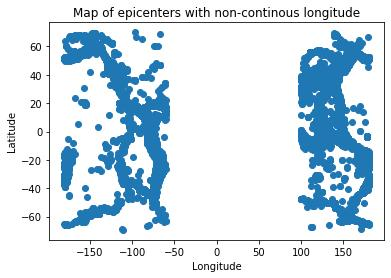

In [20]:
# latitude with non-continous scale
plt.scatter(earthquakes_engineered['lon'], earthquakes_engineered['lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of epicenters with non-continous longitude')
plt.show()

Add new columns ...


,lon,geo_x,lat,geo_y
0,-83.3550,276.6450,8.5430,8.5430
1,-177.1690,182.8310,-29.4000,-29.4000
2,121.9190,121.9190,0.3120,0.3120
3,102.5430,102.5430,24.1850,24.1850
4,102.4390,102.4390,24.1800,24.1800
...,...,...,...,...
63768,-66.8640,293.1360,17.8846,17.8846
63769,125.3963,125.3963,4.6867,4.6867
63770,151.7733,151.7733,-5.5011,-5.5011
63771,142.8218,142.8218,27.8371,27.8371


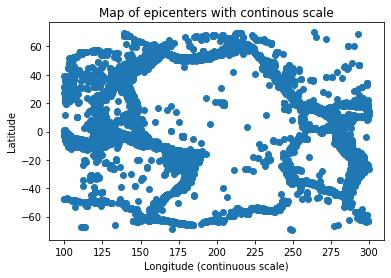

In [21]:
# add columns geo_x and geo_y (but preserve lon and lat)
try:
    # lat for geo_y should not be changed, fill geo_x with NaN
    print("Add new columns ...")
    earthquakes_engineered.insert(1, "geo_y", earthquakes_engineered['lat'])
    earthquakes_engineered.insert(1, "geo_x", np.nan)

except ValueError as e:
    # be verbose if this has already been done
    print(f"Error: {e}. Continue with calculations ...")   
    
# calculate the continuous geo_x value for longitude
earthquakes_engineered['geo_x'] = earthquakes_engineered.apply(lambda x: calculate_geo_x(x['lon']), axis = 1)

# show new parts of dataframe
display(earthquakes_engineered[['lon', 'geo_x', 'lat', 'geo_y']])

# Map (scatterplot of geo_x and geo_y)
#plt.figure(figsize = (16, 8))
plt.scatter(earthquakes_engineered['geo_x'], earthquakes_engineered['geo_y'])
plt.xlabel('Longitude (continuous scale)')
plt.ylabel('Latitude')
plt.title('Map of epicenters with continous scale')
plt.show()

The previous figure shows the location of all earthquakes from the chosen study area correctly being displayed on a map. The map does not use any geometrical projection but keeps the basic information.

#### Geometry (lat/lon)
The lat/lon coordinates needs to be converted for displaying them on a map with appropriate projection methods and libraries.

In [22]:
# create a geometry column
earthquakes_engineered['geometry'] = earthquakes_engineered.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# show new parts of dataframe
display(earthquakes_engineered[['geometry']])

,geometry
0,POINT (-83.355 8.543)
1,POINT (-177.169 -29.4)
2,POINT (121.919 0.312)
3,POINT (102.543 24.185)
4,POINT (102.439 24.18)
...,...
63768,POINT (-66.864 17.8846)
63769,POINT (125.3963 4.6867)
63770,POINT (151.7733 -5.5011)
63771,POINT (142.8218 27.8371)


#### Show the preliminary results
The final results are shown for categorical and numerical data in the whole dataset.

In [23]:
# show the resulting datasets (all dtypes but only 20 lines (standard) of the dataframe)
pd.set_option('display.max_rows', None)
print("\nShape:\n" + str(earthquakes_engineered.shape))
print("\nColumns and DataTypes:\n" + str(earthquakes_engineered.dtypes))
pd.set_option('display.max_rows', 20)
display(earthquakes_engineered)


Shape:
(63773, 20)

Columns and DataTypes:
id           object
geo_x       float64
geo_y       float64
timeymd      object
year         object
lon         float64
lat         float64
depth       float64
mag         float64
time          int64
felt        float64
cdi         float64
mmi         float64
alert        object
status       object
tsunami       int64
nst           int64
net          object
sig         float64
geometry     object
dtype: object


,id,geo_x,geo_y,timeymd,year,lon,lat,depth,mag,time,felt,cdi,mmi,alert,status,tsunami,nst,net,sig,geometry
0,iscgem799554,276.6450,8.5430,1970-01-01,1970,-83.3550,8.5430,15.00,5.44,6226830,NaN,NaN,NaN,NaN,reviewed,0,455,iscgem,NaN,POINT (-83.355 8.543)
1,iscgem799588,182.8310,-29.4000,1970-01-01,1970,-177.1690,-29.4000,35.00,5.61,61860630,NaN,NaN,NaN,NaN,reviewed,0,484,iscgem,NaN,POINT (-177.169 -29.4)
2,iscgem799702,121.9190,0.3120,1970-01-04,1970,121.9190,0.3120,146.40,5.54,289882530,NaN,NaN,NaN,NaN,reviewed,0,472,iscgem,NaN,POINT (121.919 0.312)
3,iscgem799712,102.5430,24.1850,1970-01-04,1970,102.5430,24.1850,11.30,7.10,320441090,NaN,NaN,8.862,NaN,reviewed,0,776,iscgem,NaN,POINT (102.543 24.185)
4,iscgem799715,102.4390,24.1800,1970-01-04,1970,102.4390,24.1800,15.00,5.56,322359090,NaN,NaN,NaN,NaN,reviewed,0,476,iscgem,NaN,POINT (102.439 24.18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63768,pr2019363002,293.1360,17.8846,2019-12-29,2019,-66.8640,17.8846,6.00,5.00,1577581560130,339.0,5.5,5.426,green,reviewed,0,571,pr,18.0,POINT (-66.864 17.8846)
63769,us70006s54,125.3963,4.6867,2019-12-29,2019,125.3963,4.6867,23.96,5.40,1577610735869,NaN,NaN,3.748,green,reviewed,0,449,us,NaN,POINT (125.3963 4.6867)
63770,us70006s6z,151.7733,-5.5011,2019-12-29,2019,151.7733,-5.5011,35.00,5.10,1577627942410,NaN,NaN,NaN,NaN,reviewed,0,400,us,NaN,POINT (151.7733 -5.5011)
63771,us70006sbu,142.8218,27.8371,2019-12-30,2019,142.8218,27.8371,17.30,5.10,1577679070184,1.0,3.4,NaN,NaN,reviewed,0,400,us,NaN,POINT (142.8218 27.8371)


In [24]:
# list categorical columns
cat_col = get_categorical_columns(earthquakes_engineered)
print("Categorical Columns:\n", cat_col)

Categorical Columns:
 ['id', 'timeymd', 'year', 'alert', 'status', 'net', 'geometry']


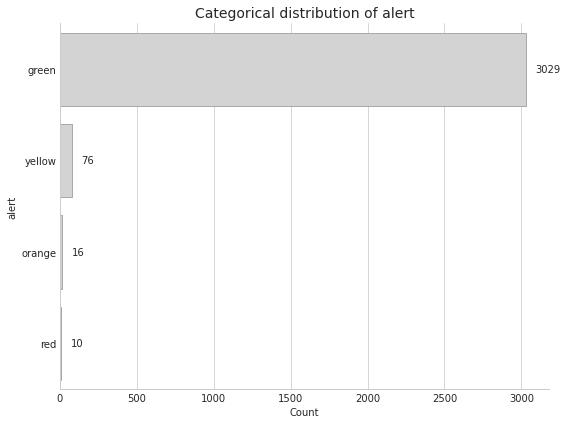

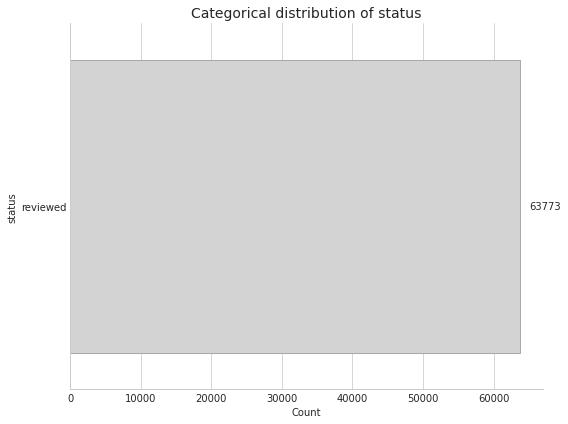

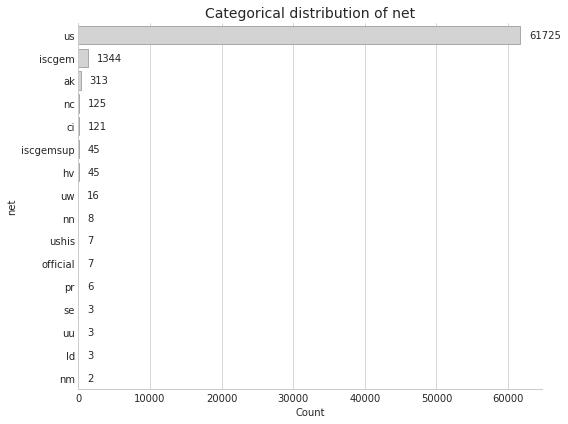

In [25]:
# alert (Alert level of the PAGER earthquake impact scale)
fig1 = plot_categorical_distribution(earthquakes_engineered, 'alert')
plt.show()

# status (reviewed if an event has been reviewed by a human, otherwise automatic)
fig2 = plot_categorical_distribution(earthquakes_engineered, 'status')
plt.show()

# net (This is the info which monitoring network has provided the event)
fig3 = plot_categorical_distribution(earthquakes_engineered, 'net')
plt.show()

In [26]:
# list numeric columns
num_col = get_numerical_columns(earthquakes_engineered)
print("Numerical Columns:\n", num_col)

Numerical Columns:
 ['geo_x', 'geo_y', 'lon', 'lat', 'depth', 'mag', 'time', 'felt', 'cdi', 'mmi', 'tsunami', 'nst', 'sig']


In [27]:
# describe numeric data
display(earthquakes_engineered[num_col].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
geo_x,63773.0,1.745167e+02,5.300438e+01,100.006,1.379940e+02,1.600030e+02,1.852010e+02,2.999680e+02
geo_y,63773.0,6.275540e-01,2.706444e+01,-69.387,-1.828900e+01,-5.196000e+00,1.743900e+01,6.999900e+01
lon,63773.0,4.364819e+01,1.344986e+02,-179.997,-8.677200e+01,1.260180e+02,1.476495e+02,1.800000e+02
lat,63773.0,6.275540e-01,2.706444e+01,-69.387,-1.828900e+01,-5.196000e+00,1.743900e+01,6.999900e+01
depth,63773.0,7.871080e+01,1.249385e+02,0.000,2.290000e+01,3.300000e+01,6.800000e+01,7.000000e+02
mag,63773.0,5.373274e+00,4.197331e-01,5.000,5.100000e+00,5.200000e+00,5.500000e+00,9.100000e+00
time,63773.0,8.335238e+11,4.426893e+11,6226830.000,4.547837e+11,8.205034e+11,1.238063e+12,1.577791e+12
felt,6254.0,2.011586e+02,2.669311e+03,0.000,1.000000e+00,6.000000e+00,2.600000e+01,1.312770e+05
cdi,6254.0,3.633195e+00,1.844992e+00,0.000,2.200000e+00,3.800000e+00,4.800000e+00,9.100000e+00
mmi,9827.0,4.794720e+00,1.534205e+00,0.000,4.035000e+00,4.783000e+00,5.833500e+00,1.000000e+01


2025-01-10 13:16:32,418 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-10 13:16:32,421 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


tsunami (indicates if a tsunami warning has been issued)


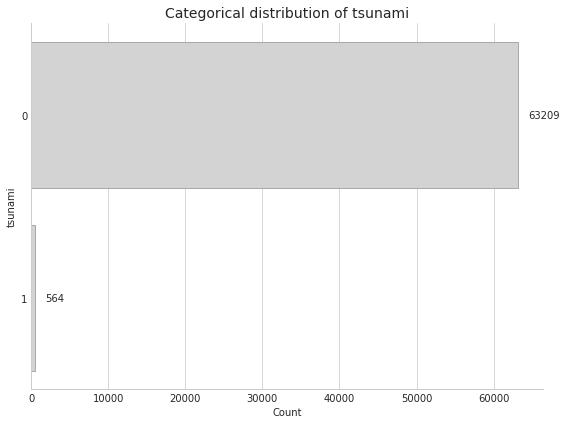


depth (depth of earthquake’s hypocentre in km below surface)


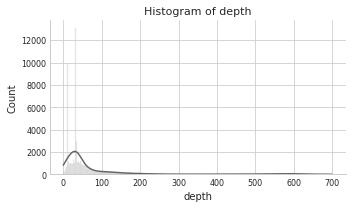

,depth
count,63773.000000
mean,78.710798
std,124.938509
min,0.000000
25%,22.900000
50%,33.000000
75%,68.000000
max,700.000000



cdi (maximum reported intensity for the event)


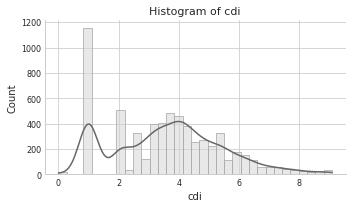

,cdi
count,6254.000000
mean,3.633195
std,1.844992
min,0.000000
25%,2.200000
50%,3.800000
75%,4.800000
max,9.100000



mmi (maximum estimated instrumental intensity for the event)


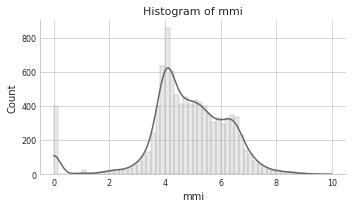

,mmi
count,9827.000000
mean,4.794720
std,1.534205
min,0.000000
25%,4.035000
50%,4.783000
75%,5.833500
max,10.000000



nst (number of recording seismic stations)


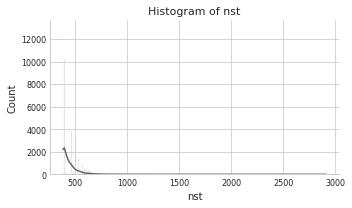

,nst
count,63773.000000
mean,450.322942
std,90.082928
min,385.000000
25%,400.000000
50%,416.000000
75%,466.000000
max,2910.000000



sig (significance of the earthquake)


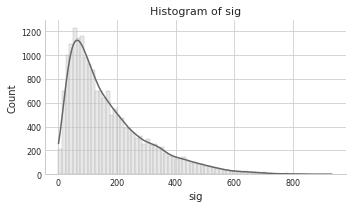

,sig
count,19328.000000
mean,170.855132
std,136.239707
min,0.000000
25%,68.000000
50%,130.000000
75%,237.000000
max,934.000000


In [28]:
# tsunami (indicates if a tsunami warning has been issued, which is a binary value of 0 and 1)
print("tsunami (indicates if a tsunami warning has been issued)")
print("============================================================")
tsunami_converted = earthquakes_engineered['tsunami'].astype(str).to_frame()
tsunami_converted.rename(columns={tsunami_converted.columns[0]: 'tsunami'})
fig11 = plot_categorical_distribution(tsunami_converted, 'tsunami')
plt.show()
print()

# depth (depth of earthquake’s hypocentre in km below surface)
print("depth (depth of earthquake’s hypocentre in km below surface)")
print("============================================================")
fig12 = plot_numerical_distribution(earthquakes_engineered, 'depth')
plt.show()
display(get_statistical_values(earthquakes_engineered, 'depth'))
print()

# cdi (maximum reported intensity for the event)
print("cdi (maximum reported intensity for the event)")
print("============================================================")
fig14= plot_numerical_distribution(earthquakes_engineered, 'cdi')
plt.show()
display(get_statistical_values(earthquakes_engineered, 'cdi'))
print()

# mmi (maximum estimated instrumental intensity for the event)
print("mmi (maximum estimated instrumental intensity for the event)")
print("============================================================")
fig14= plot_numerical_distribution(earthquakes_engineered, 'mmi')
plt.show()
display(get_statistical_values(earthquakes_engineered, 'mmi'))
print()

# nst (number of recording seismic stations)
print("nst (number of recording seismic stations)")
print("============================================================")
fig14= plot_numerical_distribution(earthquakes_engineered, 'nst')
plt.show()
display(get_statistical_values(earthquakes_engineered, 'nst'))
print()

# sig (significance of the earthquake)
print("sig (significance of the earthquake)")
print("============================================================")
fig14= plot_numerical_distribution(earthquakes_engineered, 'sig')
plt.show()
display(get_statistical_values(earthquakes_engineered, 'sig'))
print()    

## Selecting
The final earthquake dataset is selected according to the follwing contraints:

+ Study area with a bounding box of longitude [100°;-60°] and latitude [-70°;70°].
+ Earthquakes with Mw≥5.0.
+ The time period is set to 5 complete decades, with t=[01.01.1970; 31.12.2019].

These parameters have been used for scraping the data but will be checked here again. All scraped, cleaned and engineered data is inside the specified parameters for this research.

In [29]:
# make a deep copy of the dataset for further processing
earthquakes_selected = earthquakes_engineered.copy()
logging.info(f"{script_name}: Used dataset is 'earthquakes_selected' with {earthquakes_selected.shape}.")

2025-01-10 13:16:34,990 - INFO - 20_engineer_earthquake_data.ipynb: Used dataset is 'earthquakes_selected' with (63773, 20).


In [30]:
# find min and max values for each relevant column / feature
min_mag = earthquakes_selected['mag'].min()
max_mag = earthquakes_selected['mag'].max()

min_time = earthquakes_selected['timeymd'].min()
max_time = earthquakes_selected['timeymd'].max()

# show min and max values
print(f"Mag: min = {min_mag}, max = {max_mag}")
print(f"Time: min = {min_time}, max = {max_time}")

Mag: min = 5.0, max = 9.1
Time: min = 1970-01-01, max = 2019-12-31


In [31]:
# count rows that are outside the specified conditions for longitude
outside_conditions_count_lat = earthquakes_selected[
    ~((earthquakes_selected['lon'].between(100, 180)) |
      (earthquakes_selected['lon'].between(-180, -60))
     )
].shape[0]

# count rows that are outside the specified conditions for latitude
outside_conditions_count_lon = earthquakes_selected[
    ~(earthquakes_selected['lat'].between(-70, 70))
].shape[0]

# print count of lon coordinates outside the specified bounding box
print(f"Lat coordinates outside bounding box: {outside_conditions_count_lat}")
print(f"Lon coordinates outside bounding box: {outside_conditions_count_lon}")

Lat coordinates outside bounding box: 0
Lon coordinates outside bounding box: 0


## Save cleaned, engineered, and selected earthquake dataset

In [32]:
# save earthquake dataset
save_dataset(data_file = "earthquakes_selected.csv", 
             data_dir = data_dir, 
             data_set = earthquakes_selected
            )  

2025-01-10 13:16:35,873 - INFO - save_dataset: Data saved successfully to 'data/earthquakes_selected_250110-131635.csv'.


## End of script

In [33]:
# log the end of this script
logging.info(f"End of script '{script_name}'.")

2025-01-10 13:16:35,876 - INFO - End of script '20_engineer_earthquake_data.ipynb'.


## Appendix

In [34]:
%%js

// -------------------------------------------
// What are the headings of this document?
// --> Get a better overview of the structure.
// -------------------------------------------

function listHeadings() {
    let headings = [];
    let cells = Jupyter.notebook.get_cells();
    
    cells.forEach((cell) => {
        if (cell.cell_type == 'markdown') {
            let text = cell.get_text();
            let lines = text.split('\n');
            
            lines.forEach((line) => {
                let match = line.match(/^(#+)\s+(.*)/);
                if (match) {
                    headings.push({
                        level: match[1].length, // Number of # symbols indicates the heading level
                        text: match[2].trim()
                    });
                }
            });
        }
    });
    return headings;
}

let headings = listHeadings();
headings.forEach((heading) => {
    let markdown = `${'#'.repeat(heading.level)} ${heading.text}`;
    element.append(`${markdown}<br>`);
});

<IPython.core.display.Javascript object>